# **ML vs SML vs Time Series Analysis**

N.B. Some variables will be declared in all uppercase, this means that these variables will be reuse during different sections of the notebook.

In [1]:
%matplotlib inline
# Loading the dataset
import os
import pandas as pd

# Load the dataset
data = pd.read_csv(os.path.join('data', 'day.csv'))

In [2]:
############ BASIC PREPROCESSING  ############

# Convert the date column to a datetime object
data['dteday'] = pd.to_datetime(data['dteday'])
# Set the date column as the index
data.set_index('dteday', inplace=True)
# Remove unnecessary labels ("registered, "casual", and "instant")
DATA = data.drop(['casual', 'registered', 'instant'], axis=1)
# Extract the features names
FEATURES = DATA.columns[:-1]
# Define the target variable
LABEL = 'cnt'

## **Features of the datasets**

Here we have reported the features that are present in the original datasets.
The features are divided in two big categories: the first "Time Features" collects everything that specify the time of which that specific data point is referring to, while the second category "Atmospheric Features" group all the information available about the weather, temperature, and humidity at a specific time/date.

<style>
* {
  box-sizing: border-box;
}

.row {
  margin-left:-5px;
  margin-right:-5px;
}
  
.column {
  float: left;
  width: 50%;
  padding: 50px;
}

/* Clearfix (clear floats) */
.row::after {
  content: "";
  clear: both;
  display: table;
}

table {
  border-collapse: collapse;
  border-spacing: 0;
  width: 100%;
  border: 1px solid #ddd;
}

th, td {
  text-align: left;
  padding: 16px;
}

</style>
</head>
<body>

<div class="row">
  <div class="column">
    <center><b>Time Features</b></center>
    <table>
      <tr>
        <th><center>Feature name</center></th>
        <th><center>Description</center></th>
      </tr>
      <tr>
        <td><center>dteday</center></td>
        <td>Full date (yyyy-mm-dd)</td>
      </tr>
      <tr>
        <td><center>season</center></td>
        <td>Season (1: Spring, 2: Summer, 3: Fall, 4: Winter)</td>
      </tr>
      <tr>
        <td><center>yr</center></td>
        <td>Year (0: 2011, 1:2012)</td>
      </tr>
      <tr>
        <td><center>mnth</center></td>
        <td>Month (1 to 12)</td>
      </tr>
      <tr>
        <td><center>holiday</center></td>
        <td>Day is holiday or not</td>
      </tr>
      <tr>
        <td><center>weekday</center></td>
        <td>Day of the week (0 to 7)</td>
      </tr>
      <tr>
        <td><center>workingday</center></td>
        <td>If day is neither weekend nor holiday is 1, otherwise is 0</td>
      </tr>
    </table>
  </div>
  <div class="column">
    <center><b>Atmospheric Features</b></center>
    <table>
      <tr>
        <th><center>Feature name</center></th>
        <th><center>Description</center></th>
      </tr>
      <tr>
        <td><center>weathersit</center></td>
        <td>Type of weather of the day/hour (Clear, Cloudy, Rain, etc...)</td>
      </tr>
      <tr>
        <td><center>temp</center></td>
        <td>Normalized temperature in Celsius. The values are divided to 41 (max)</td>
      </tr>
      <tr>
        <td><center>atemp</center></td>
        <td>Normalized feeling temperature in Celsius. The values are divided to 50 (max)</td>
      </tr>
      <tr>
        <td><center>hum</center></td>
        <td>Normalized humidity. The values are divided to 100 (max)</td>
      </tr>
      <tr>
        <td><center>windspeed</center></td>
        <td>Normalized wind speed. The values are divided to 67 (max)</td>
      </tr>
    </table>
  </div>
</div>

</body>
</html>

Our problem is trying to predict how many customer will take a bike on a specific date, thus our target variable is **cnt** (that is the count of total rental bikes including both casual and registered).<br>
We also have available the breakdown between how many bikes were rented by casual or registered customers, but we will not focus on that in this notebook. An interesting exercise could be repeat everything that we're going to do focusing only on registered customers or casual ones.

## **Some visualization**

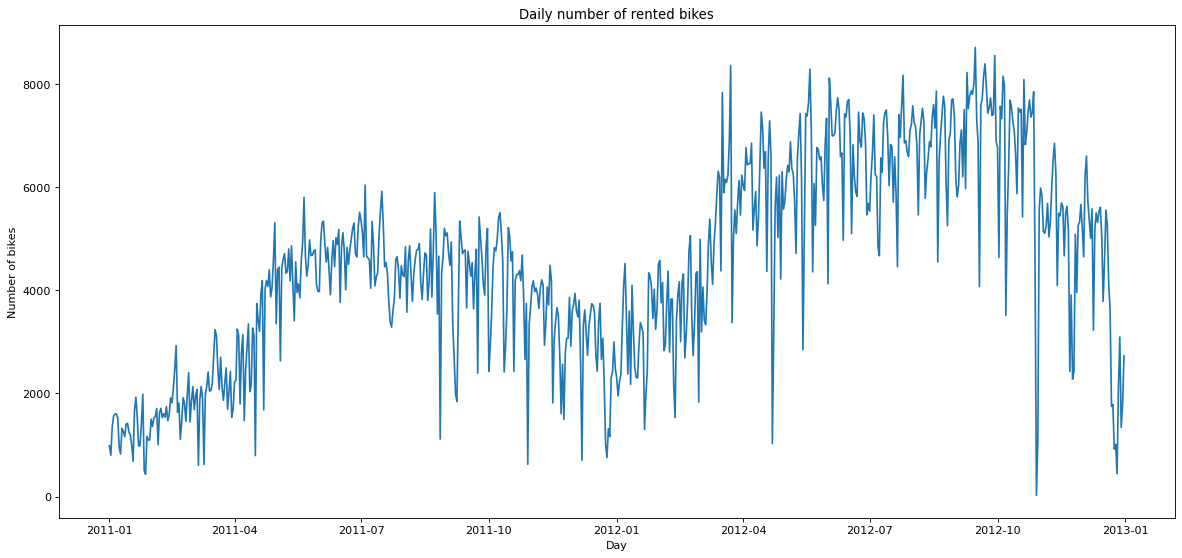

In [3]:
import matplotlib.pyplot as plt

def plot_data(data, title: str, x_axis: str, y_axis: str):
    plt.figure(figsize=(18, 8), dpi=80)
    
    # Create a line plot of the time series
    if type(data) != list:
        plt.plot(data[LABEL])
    else:
        for block in data:
            plt.plot(block[LABEL])

    # Add custom title to the plot
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)

    # Show the plot
    plt.show()

plot_data(DATA, "Daily number of rented bikes", "Day", "Number of bikes")

## **How to compare the streaming approach to the traditional one?**

As in any good Machine Learning pipeline, to be confident in our final results we can't simply define a single split between train and test set, and call it a day. This modus operandi will lead us to biased results, thus we have the necessity of using some kind of cross-validation. Generally, k-folds cross-validation is the easiest and best choice, but does is really makes sense with our dataset?

Well... not in its standard form. If we simply sampled at random our dataset to form k folds, we would end up destroying the time-relation between the data points. Thus, we need to find another way that makes more sense.

What we are going to do is to create k blocks of **consecutive** data points. Then, we are going to use these blocks to do some **incremental backtesting**. This techniques is simple, but really effective when dealing with time series: the idea is that, given N data blocks, we first train on block [0] and test on block [1], then we train on blocks [0,1] and test on block [2], etc...

<style>
  .responsive-image {
    max-width: 66%;
    height: auto;
  }
</style>

<img class="responsive-image" src="imgs/cv_ts.png" alt="Cross-validation visualization">

Now that we've enstablished how we will evaluate all of out models, we need to create these blocks!
We will divide all the dataset is 24 blocks, that roughly correspond to one month each.

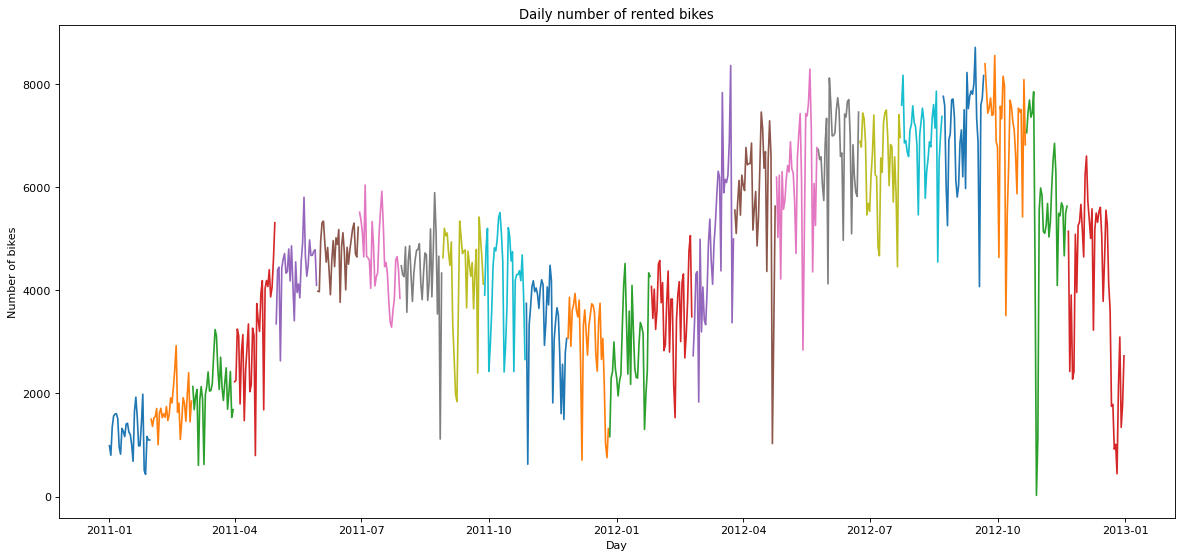

In [4]:
# Define how many data blocks we  have
NUM_BLOCKS = 24

# Create the 5 block of data
block_length = int(round(len(DATA) / NUM_BLOCKS, 0))
BLOCKS = []
base_idx = 0
for _ in range(NUM_BLOCKS-1):
    BLOCKS.append(DATA.iloc[base_idx:base_idx+block_length, :])
    base_idx += block_length
BLOCKS.append(DATA.iloc[base_idx:, :])

plot_data(BLOCKS, "Daily number of rented bikes", "Day", "Number of bikes")

## **Let's enstablish a baseline**

The first step when we are training multiple models, is to enstablish a baseline performance. This will help us put into perspective the results of each approach to our problem. 

We will use mainly 3 metrics to evaluate our models:
- *MAE* (Mean Absolute Error)
- *RMSE* (Root Mean Square Error)
- *R<sup>2</sup>* (R Squared)
- *MAPE* (Mean Absolute Percentage Error)

There are multiple naive ways to implement a simple baseline for a time series, but we will simply predict **y<sub>t+1</sub> = y<sub>t</sub>**, given that generally this is the simplest and best method. Furthermore, in order to compare the performance of the traditional ML approach (based on periodic re-training over N data blocks) with the others, we will also take N-1 snapshots of the cumulative performance of SML models that corresponds to the end of each of the N-1 blocks used for testing.

In [5]:
import numpy as np

def plot_metrics(metrics):
    mae, rmse, mape, r2 = zip(*metrics)
    max_len = len(mae)

    plt.figure(figsize=(16, 12), dpi=80)

    plt.subplot(2, 2, 1)
    plt.plot(mae, marker='o')
    plt.title('MAE')
    plt.xlabel('Block')
    plt.xticks(range(max_len), range(1, max_len+1))
    
    plt.subplot(2, 2, 2)
    plt.plot(rmse, marker='o')
    plt.title('RMSE')
    plt.xlabel('Block')
    plt.xticks(range(max_len), range(1, max_len+1))

    plt.subplot(2, 2, 3)
    plt.plot(mape, marker='o')
    plt.title('MAPE')
    plt.xlabel('Block')
    plt.xticks(range(max_len), range(1, max_len+1))

    plt.subplot(2, 2, 4)
    plt.plot(r2, marker='o')
    plt.title('R2')
    plt.xlabel('Block')
    plt.xticks(range(max_len), range(1, max_len+1))

    plt.show()

def evaluate_final(metrics):
    maes, rmses, mapes, r2s = zip(*metrics)

    print('Final performance\n')
    print(f'MAE')
    print(f'  - Mean:  {np.mean(maes)}')
    print(f'  - Stdev: {np.std(maes)}')
    print(f'RMSE')
    print(f'  - Mean:  {np.mean(rmses)}')
    print(f'  - Stdev: {np.std(rmses)}')
    print(f'MAPE')
    print(f'  - Mean:  {np.mean(mapes)}')
    print(f'  - Stdev: {np.std(mapes)}')
    print(f'R2')
    print(f'  - Mean:  {np.mean(r2s)}')
    print(f'  - Stdev: {np.std(r2s)}')
    print("*"*35)

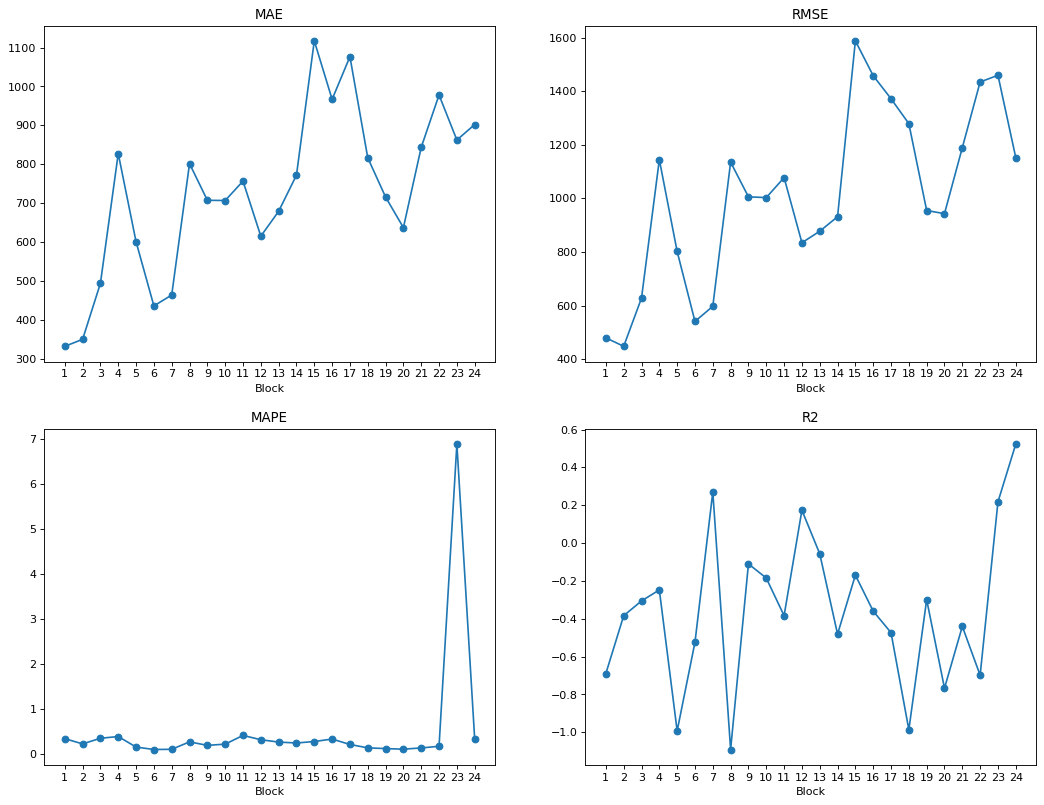

Final performance

MAE
  - Mean:  727.5972899728998
  - Stdev: 207.17633313722826
RMSE
  - Mean:  1013.9132142963402
  - Stdev: 319.40082238259544
MAPE
  - Mean:  0.5073474796664644
  - Stdev: 1.333021671245737
R2
  - Mean:  -0.35243861430081463
  - Stdev: 0.3984825659956334
***********************************


In [6]:
from river.stream import iter_pandas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# First, we create a stream using the full dataset frame
stream = iter_pandas(X=data[FEATURES], y=data[LABEL])

# Now it's time to "train" and evaluate the "model"
y_old, idx = 0, 0
metrics = []
for block_idx in range(len(BLOCKS)):
    # Get the block used for training
    train = BLOCKS[block_idx]
    # "Train" the model over the current block
    trues, preds = [], []
    for xi, yi in iter_pandas(X=train[FEATURES], y=train[LABEL]):
        #  Save the predicted and true values
        trues.append(yi), preds.append(y_old)
        y_old = yi

    metrics.append((
        mean_absolute_error(trues, preds),
        np.sqrt(mean_squared_error(trues, preds)),
        mean_absolute_percentage_error(trues, preds),
        r2_score(trues, preds)
                   ))

plot_metrics(metrics)
evaluate_final(metrics)

Here we have recorded how all the metrics evolved after every new block was added to the training, while also providing a summarized view of the models.

The most important metric among these 4 is the MAPE because the absolute value of bikes rented varies significantly between different portions of the year, starting around a mean of 2000 and having a peak of more than 8000! This extreme variation may severely impact our analysis if we focus on non-normalized metrics like the MAE and RMSE.

*If you already understood why we are chosing MAPE as our main metric, you can skip this part and go on with the notebook, otherwise let's look at a simple example.*

Let's say that for our **1st block** we have made a **MAE of 310** and we had the **same error for the 22nd block**. Looking only at the absolute value of these errors, we may say that our model had exactly the same performance for both these blocks. But if we look at the mean target value for each block, we then discover that the 1st block had a mean of about 1000 rented bikes, while the 22nd had a mean of about 7500. And this means that the relative **error for our first block is much more significant than the one for the 22nd block**, because we are comparing a **100\*(310/1000) = 31%** error to a **100\*(310/7500) = 4.1% error**.

## Some miscellanous plotting methods

Before continuing with the notebook, I'll define a couple of methods used for plotting. It's nothing particularly useful to look at, so you can skip this section and go directly to the first approach.

In [30]:
def plot_sml(data, title: str, x_axis: str, y_axis: str, names=None):
    plt.figure(figsize=(16, 4), dpi=80)
    if not names:
        plt.plot(data)
    else:
        for model_data, model_name in zip(data, names):
            plt.plot(model_data, label=model_name)

    # Add custom title to the plot
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    if names:
        plt.legend()

    # Show the plot
    plt.show()

In [71]:
def short_compare(ml, sml, model):
    plt.figure(figsize=(10, 8), dpi=80)
    max_len = len(ml)

    plt.subplot(2, 1, 1)
    plt.plot(ml, marker='o', label=f'{model[0]}')
    plt.plot(sml, marker='o', label=f'{model[1]}')
    plt.xlabel('Block')
    plt.ylabel('MAPE')
    plt.xticks(range(max_len), range(1, max_len+1))
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(ml, marker='o', label=f'{model[0]}')
    plt.plot(sml, marker='o', label=f'{model[1]}')
    plt.xlabel('Block')
    plt.ylabel('MAPE')
    plt.xticks(range(max_len), range(1, max_len+1))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.ylim(bottom=-0.05, top=1.05)
    plt.legend()
    
    plt.show()

In [41]:
# This special plot function will let us compare and summarize results for all the models in each approach

def cross_compare(metric_list: list, names: list, constrained=False, continuos=None):
    # Block by block MAPE comparison
    plt.figure(figsize=(16, 4), dpi=80)
    max_len = len(metric_list[0])

    max_val = 0
    for metrics, name in zip(metric_list, names):
        _, _, mape, _ = zip(*metrics)
        plt.plot(mape, marker='o', label=name)
        if max_val < max(mape): max_val = max(mape)
    plt.title('Model comparison')
    plt.ylabel('MAPE')
    plt.xlabel('Block')
    plt.xticks(range(max_len), range(1, max_len+1))
    if max_val <= 1:
        max_val = round(max_val, 1) + (0 if round(max_val, 1) > max_val else 0.1)
        plt.yticks(np.arange(0, max_val+0.1, step=0.1))
        plt.ylim(bottom=-0.05, top=max_val+0.05)
    else:
        plt.ylim(bottom=-0.05)
    plt.legend()
    plt.show()

    # Block by block MAPE comparison with y-axis contrains (done only if necessary)
    if constrained:
        plt.figure(figsize=(16, 4), dpi=80)
        max_len = len(metric_list[0])

        for metrics, name in zip(metric_list, names):
            _, _, mape, _ = zip(*metrics)
            plt.plot(mape, marker='o', label=name)
        plt.title('Model comparison (Y-axis constrained)')
        plt.ylabel('MAPE')
        plt.xlabel('Block')
        plt.xticks(range(max_len), range(1, max_len+1))
        plt.yticks(np.arange(0, 1.1, step=0.1))
        plt.ylim(bottom=-0.05, top=1.05)
        plt.legend()
        plt.show()

    if continuos:
        plot_sml(continuos, 'Comparative Evolution of MAPE', 'Day', 'MAPE', names)

    # Summary metrics comparison
    plt.figure(figsize=(12 if len(names)>2 else 8, 12), dpi=80)

    maes, rmses, mapes, r2s = [], [], [], []
    for metrics in metric_list:
        mae, rmse, mape, r2 = zip(*metrics)
        maes.append((np.mean(mae), np.std(mae)))
        rmses.append((np.mean(rmse), np.std(rmse)))
        mapes.append((np.mean(mape), np.std(mape)))
        r2s.append((np.mean(r2), np.std(r2)))

    for id, (data, metric) in enumerate([(maes, 'MAE'), (rmses, 'RMSE'), (mapes, 'MAPE'), (r2s, 'R2')]):
        plt.subplot(2, 2, id+1)
        means, stdevs = zip(*data)
        plt.bar(names, means, yerr=stdevs, capsize=6, color=['royalblue', 'dodgerblue', 'darkturquoise', 'black'])
        plt.title(metric)

    plt.show()

## **Traditional Machine Learning**

In this section we will explore the performance of traditional Machine Learning (ML) models when used to solve a time series regression task.

We will check 3 different models:
- KNN
- Decision Tree
- Random Forest

In [10]:
#########   EVALUATION METHODS   #########

# Define a simple function to evaluate all ml models
def evaluate_ml(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return (mae, rmse, mape, r2)

In [11]:
#########   TRAIN & TEST METHOD   #########

def train_and_test_ml(model):
    metrics = []
    train = BLOCKS[0]
    for block in BLOCKS[1:]:
        # Train the model
        model.fit(X=train[FEATURES], y=train[LABEL])
        # Test the model
        y_pred = model.predict(X=block[FEATURES])
        # Evaluate the model
        metrics.append(evaluate_ml(block[LABEL], y_pred))

        # Now we expand the training dataset
        train = pd.concat([train, block], axis=0)

    return metrics


### *KNN*

This specific algorithm is a lazy learner: the algorithm doesn't really learn any data representation or model, it simply memorizes all the data sent in input to later compare it to new data.

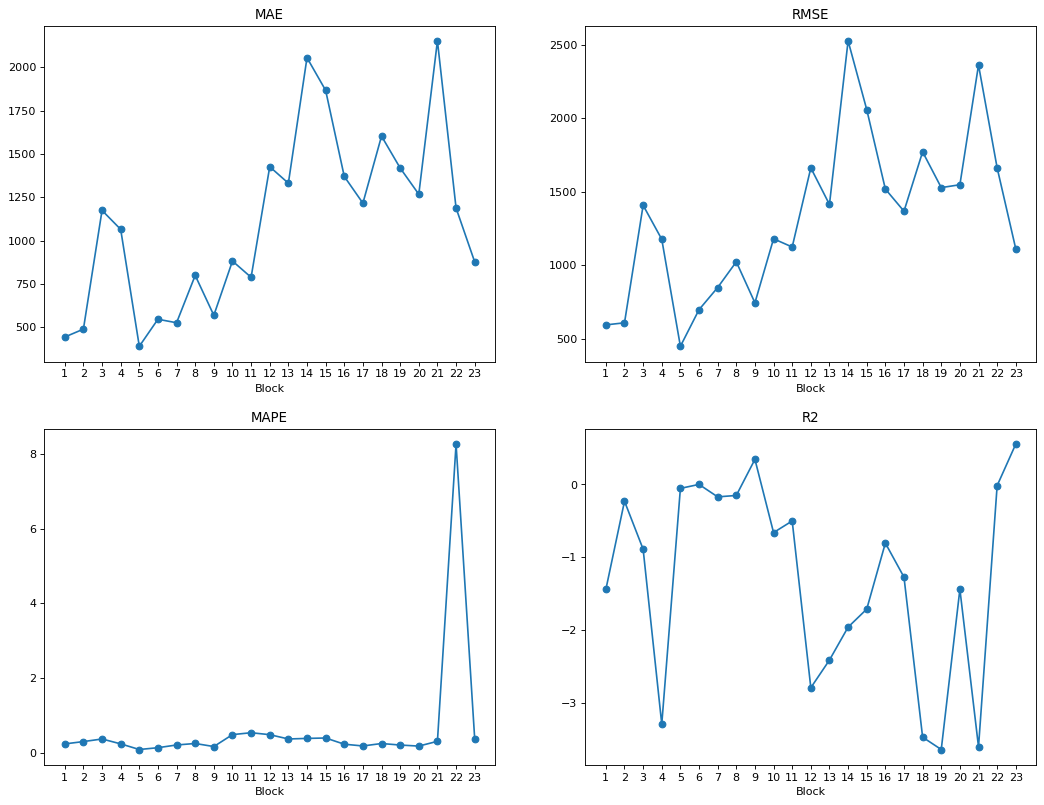

Final performance

MAE
  - Mean:  1106.7552067868503
  - Stdev: 500.23698471791056
RMSE
  - Mean:  1321.8639779091657
  - Stdev: 536.3765439345575
MAPE
  - Mean:  0.6317050948558033
  - Stdev: 1.6323491446631508
R2
  - Mean:  -1.2890200217644325
  - Stdev: 1.3170884360600243
***********************************


In [43]:
from sklearn.neighbors import KNeighborsRegressor

# Instantiate model
knn = KNeighborsRegressor()
# Train and test the model
knn_metrics = train_and_test_ml(knn)
# Plot the obtained metrics
plot_metrics(knn_metrics)
# Evaluate the model
evaluate_final(knn_metrics)


Unfortunately this model don't perform that well. All recorded metrics are significanly worse than the simple baseline that we've established.</br>
Thus, KNN should not be used to solve our problem.</br></br>
It's interesting to notice that we have a significant spike in MAPE on the 22nd block. At the start of this block the mean number of rented bike is aroung 7800, but jst after a few days, we notice an almost vertical drop for a couple of days (averaging almost 0 bikes). After this drop, the block stabilizes itself around a mean of 6000 bikes. This pattern is extremely complex to predict, and we will see that almost all model fails to manage this block.

### *Decision Tree*

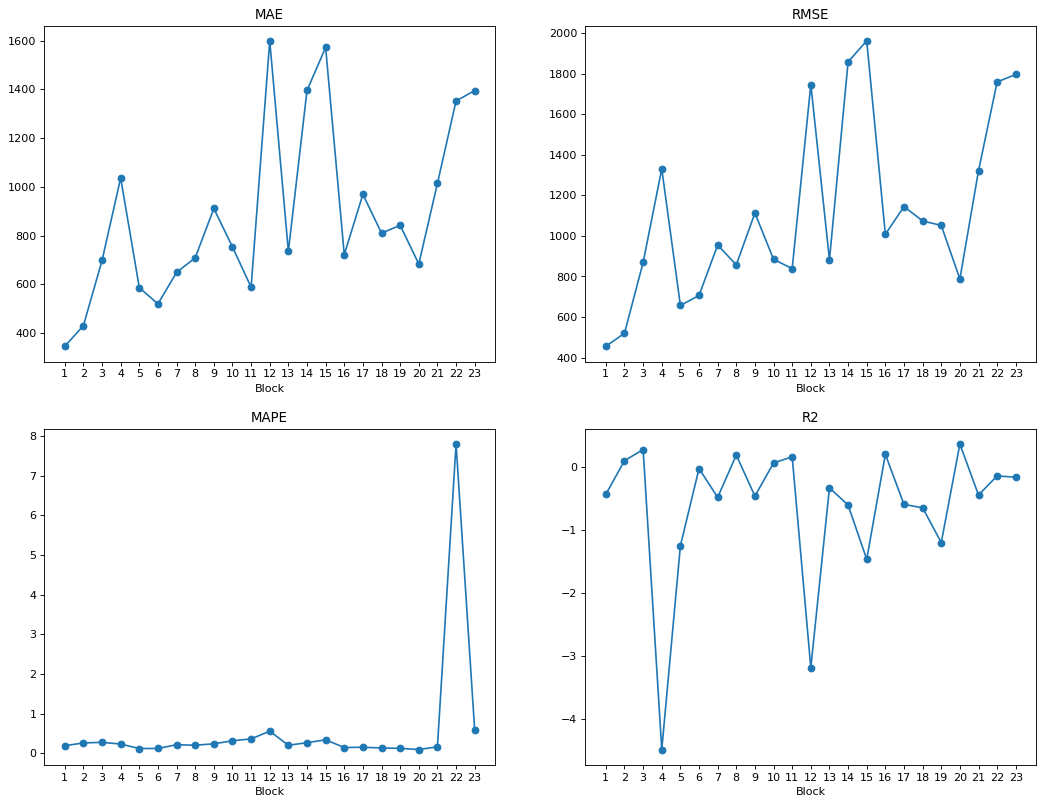

Final performance

MAE
  - Mean:  883.4270389874356
  - Stdev: 349.5879609292638
RMSE
  - Mean:  1111.9035203683964
  - Stdev: 430.52046553979693
MAPE
  - Mean:  0.5719528239630162
  - Stdev: 1.5446689423356597
R2
  - Mean:  -0.6292726013490487
  - Stdev: 1.1167822511664092
***********************************


In [44]:
from sklearn.tree import DecisionTreeRegressor

# Instantiate model
decision_tree = DecisionTreeRegressor(max_depth=12)
# Train and test the model
tree_metrics = train_and_test_ml(decision_tree)
# Plot the obtained metrics
plot_metrics(tree_metrics)
# Evaluate the model
evaluate_final(tree_metrics)

Thankfully a more compelx model brought us better performance, but not enough to beat our baseline.</br>
Once again, we see a significant MAPE spike on the 22nd block (this time was managed slightly better than what we've seen for KNN, but it's still horrible).

### *Random Forest*

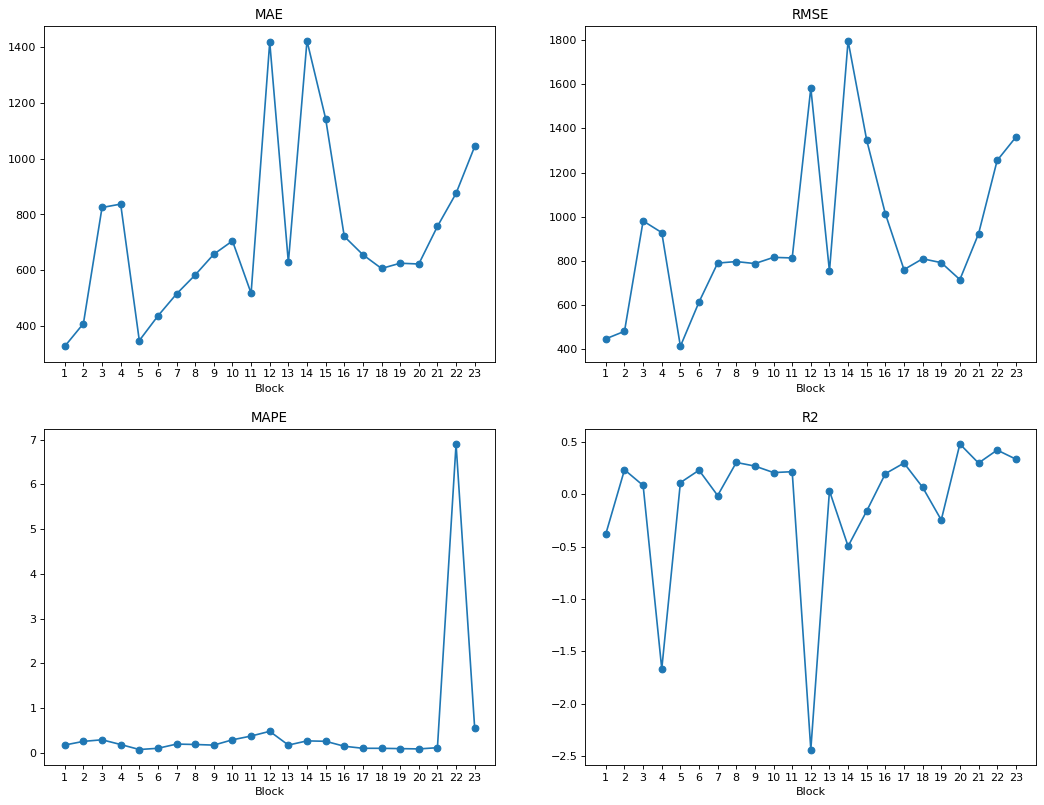

Final performance

MAE
  - Mean:  725.2975581477556
  - Stdev: 289.81585818994097
RMSE
  - Mean:  911.8240466618682
  - Stdev: 340.5889562631974
MAPE
  - Mean:  0.5042362005470988
  - Stdev: 1.368617299333967
R2
  - Mean:  -0.07036772078843401
  - Stdev: 0.6661857080114929
***********************************


In [46]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rand_forest = RandomForestRegressor()
# Train and test the model
forest_metrics = train_and_test_ml(rand_forest)
# Plot the obtained metrics
plot_metrics(forest_metrics)
# Evaluate the model
evaluate_final(forest_metrics)

With Random Forest we see the first algorithm that come close to our baseline performance! The MAPE is asbolutely comparable (less than 0.2% difference).</br>
Also, we see a similar level of MAPE for the infamous 22nd block to the one obtained in the baseline.</br></br>
We can confidently say that this algorithm is the best performing for the ML approach, and closely resembles the performance of the baseline!

## **Traditional Machine Learning Results**

This is our first section in which we directly compare all the models of the same approach (in this case traditional ML).</br></br>
In these section you'll find (at minimum) 3 figures: the first will show a comparison of the MAPE values per block of all models, the second is a zoomed version of the same figuere (so that we can better appreciate how teh MAPE changes depending on the block), and the third is a raw comparison of the mean values of all the metrics.

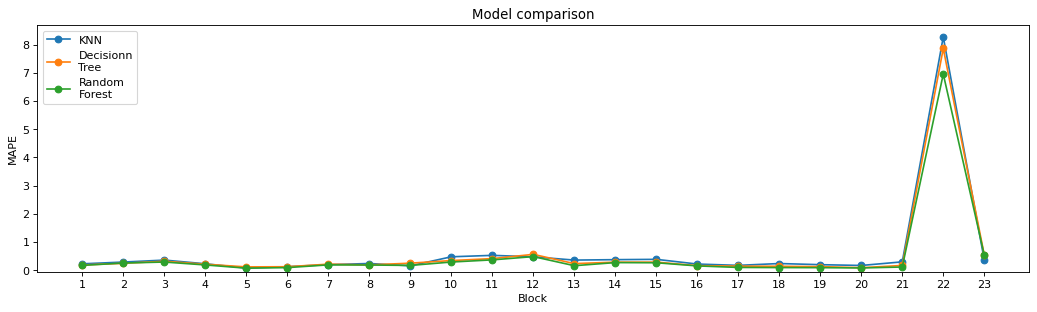

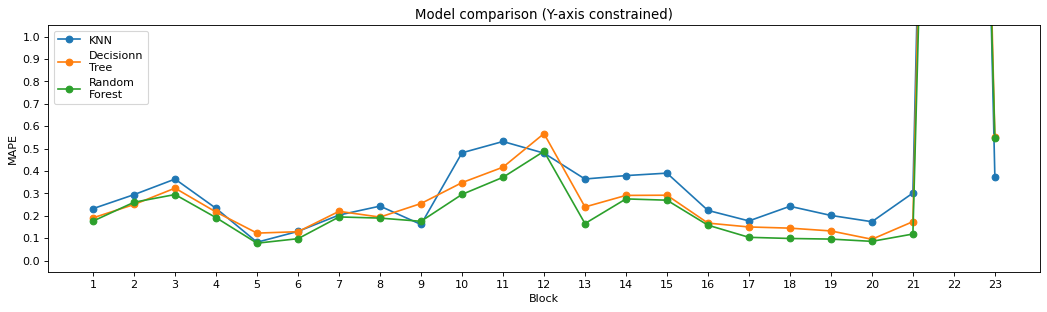

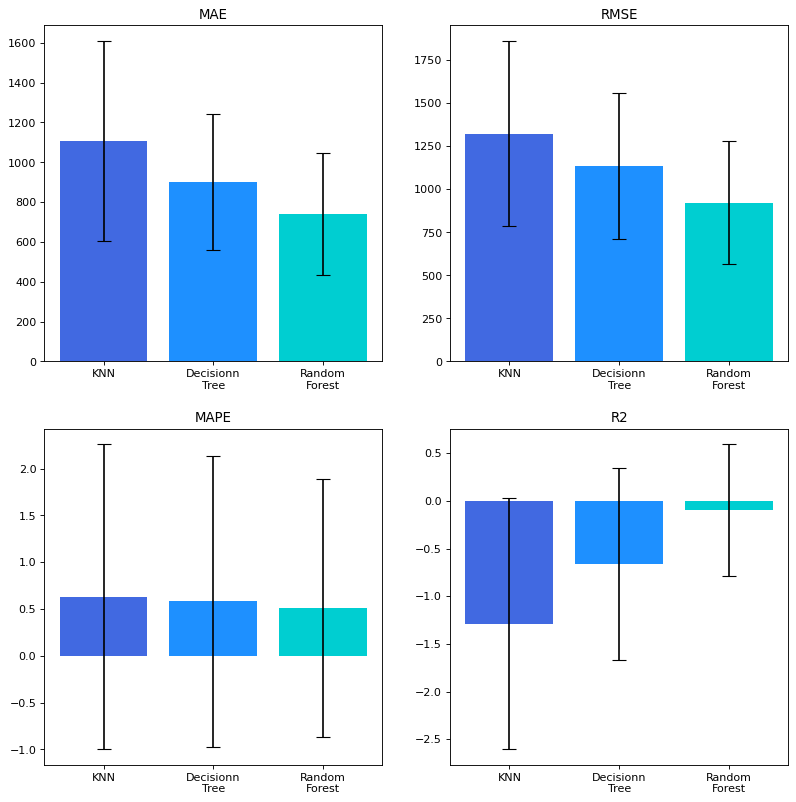

In [39]:
ml_metrics = [knn_metrics, tree_metrics, forest_metrics]
ml_model_names = ['KNN', 'Decisionn\nTree', 'Random\nForest']
cross_compare(ml_metrics, ml_model_names, constrained=True)

As expected, the close ispection of the MAPE evolution and the cumulative metrics confirms that the Random Forest model is the best ML model... Even if it guarantees us only a performance close to our baseline.</br></br>
Can we do better with other approaches?

## **Streaming Machine Learning**

To provide a better comparison, we decided to use 3 models for the Streaming Machine Learning (SML) approach that closely resemble the ones used for traditional ML:

- KNN with limited data window
- Hoeffding Adaptive Tree
- Adaptive Random Forest

Only for this specific approach, we also have access to a new plot: the continuos metric plots! This simply show "in real time" how the metrics have evolved during the training of the models.

In [16]:
#########   EVALUATION METHODS   #########

from river.metrics import MAE, RMSE, R2, MAPE

# Define a simple function to evaluate all ml models
def evaluate_sml(y_true, y_pred, metrics):
    mae, rmse, mape, r2 = metrics
    mae.update(y_true=y_true, y_pred=y_pred)
    rmse.update(y_true=y_true, y_pred=y_pred)
    mape.update(y_true=y_true, y_pred=y_pred)
    r2.update(y_true=y_true, y_pred=y_pred)

In [13]:
#########   TRAIN & TEST METHOD   #########
def _train_sml(model, train, metrics, continuos_metrics):
    mae, rmse, mape, r2 = metrics
    for xi, yi in iter_pandas(X=train[FEATURES], y=train[LABEL]):
        # Evaluate the single data point
        y_pred = model.predict_one(x=xi)
        # Update the metrics
        evaluate_sml(y_true=yi, y_pred=y_pred, metrics=metrics)
        # Record the continuous metrics
        continuos_metrics.append((mae.get(), rmse.get(), mape.get(), r2.get()))
        # Learn from the new data point
        model.learn_one(x=xi, y=yi)

def train_and_test_sml(model):
    # Metrics
    mae = MAE()
    rmse = RMSE()
    mape = MAPE()
    r2 = R2()

    metrics, continuos_metrics = [], []
    for block_idx in range(len(BLOCKS)-1):
        # Get the block used for training
        train = BLOCKS[block_idx]
        # Train the model over the current block
        _train_sml(model, train, (mae, rmse, mape, r2), continuos_metrics)
        # Now we evaluate the model the same as if it was a ML model
        test = BLOCKS[block_idx+1]
        predictions, truths = [], []
        for xi, yi in iter_pandas(X=test[FEATURES], y=test[LABEL]):
            # Evaluate the single data point
            y_pred = model.predict_one(x=xi)
            # Record the prediction and the ground truth
            predictions.append(y_pred)
            truths.append(yi)
        metrics.append(evaluate_ml(truths, predictions))
    
    # We also train over the last block to have the full curve of the continuos metrics
    _train_sml(model, BLOCKS[-1], (mae, rmse, mape, r2), continuos_metrics)    

    return metrics, continuos_metrics

### *KNN with limited data window*

This implementation of KNN keeps tracks of only the last N items that was sent as input in the model (in our case we chose 50). This will definitely give the model less data to generate its prediction, but at the same time the data that has available should be more relevant (becuase it's more recent data).

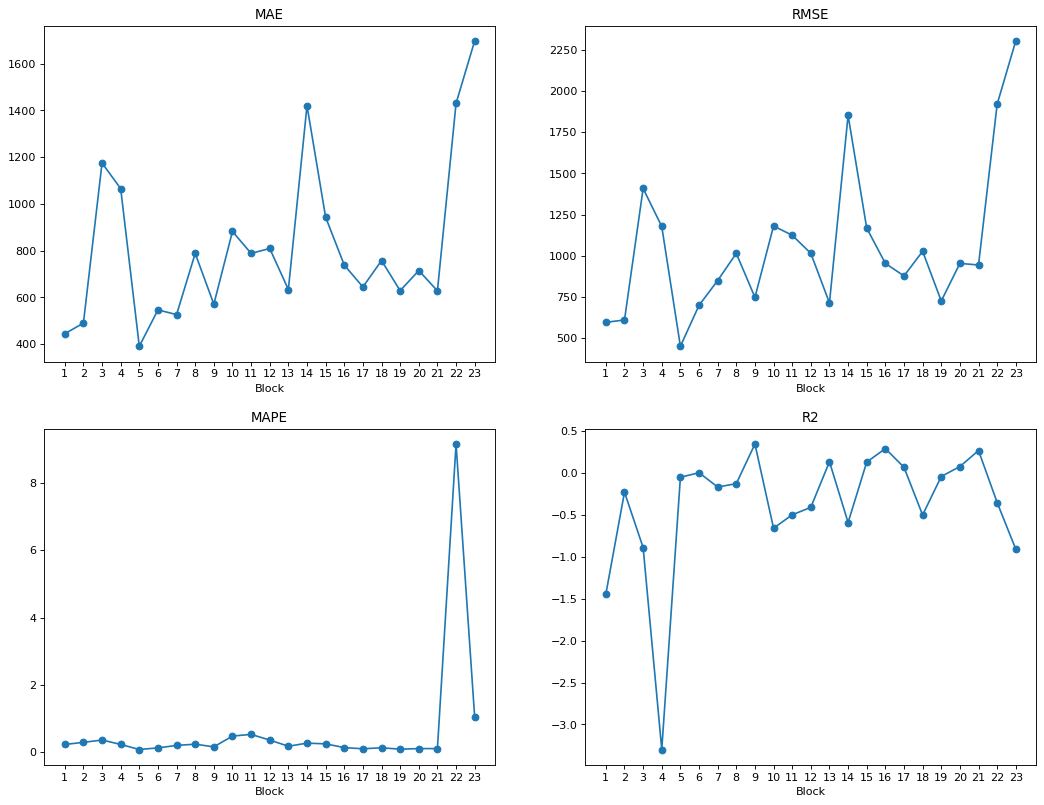

Final performance

MAE
  - Mean:  813.8580063626724
  - Stdev: 331.41213740533476
RMSE
  - Mean:  1057.1121673822956
  - Stdev: 440.2286884426992
MAPE
  - Mean:  0.6475774541813814
  - Stdev: 1.8254253989454299
R2
  - Mean:  -0.38733160235345826
  - Stdev: 0.7560338523397281
***********************************


In [17]:
from river.neighbors import KNNRegressor

# Instantiate the model
stream_knn = KNNRegressor(window_size=50)
# Train and test the model
stream_knn_metrics, knn_continuos_metrics = train_and_test_sml(stream_knn)
# Plot the obtained metrics
plot_metrics(stream_knn_metrics)
# Evaluate the model
evaluate_final(stream_knn_metrics)

Looking at the mean performance of the model, we notice that the performance are comparable with the ML version of KNN. But if we move our attention to the performance per block, we see a slightly different story (and that's why is so important to look not only at the aggregated metrics, but also at the evolution of those).</br>
Both ML KNN and SML KNN behave closely for the first 10/11 blocks, but after that the SML approach start to show its strength. This difference is due to the fact that the SML KNN only uses recent data to generate its prediction, leading to a higher performance. Even if the SML KNN is better in general, it perform worse than ML on the infamous 22 block, thus showing that the moedl is less resilient to outliear than the ML one.

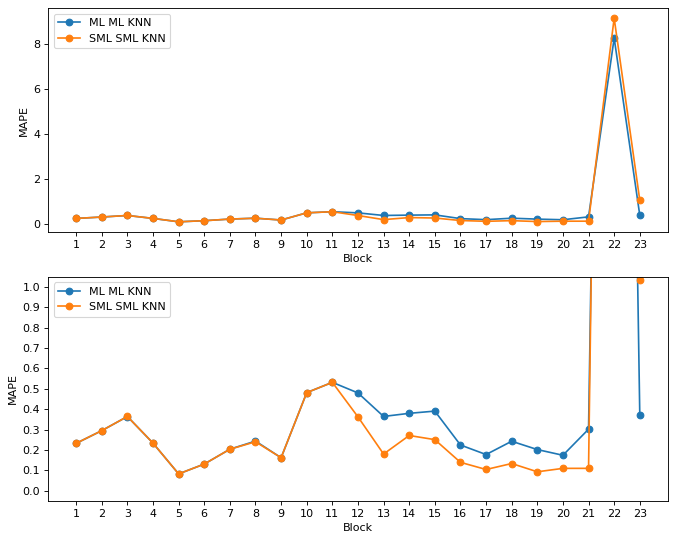

In [70]:
_, _, _ml_knn_mape, _ = zip(*knn_metrics)
_, _, _sml_knn_mape, _ = zip(*stream_knn_metrics)
short_compare(_ml_knn_mape, _sml_knn_mape, ['ML KNN', 'SML KNN'])

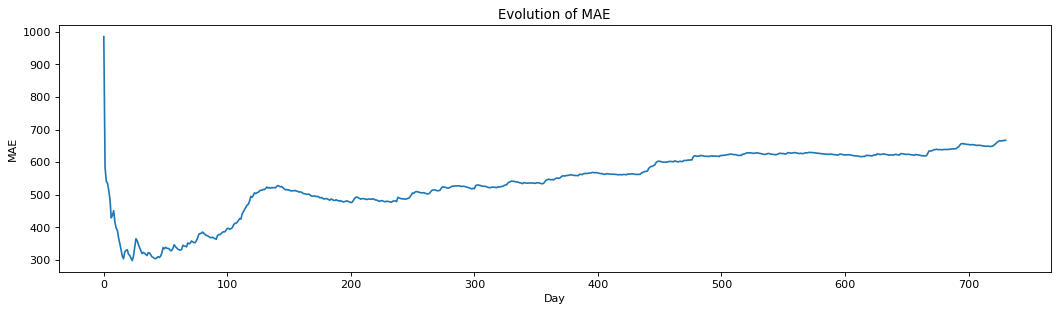

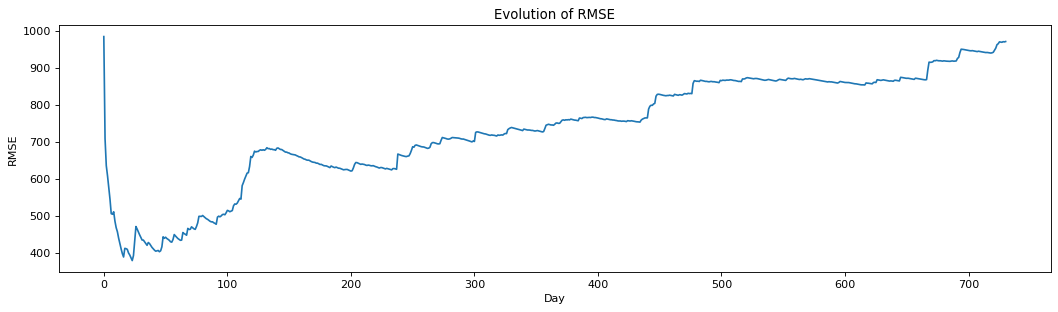

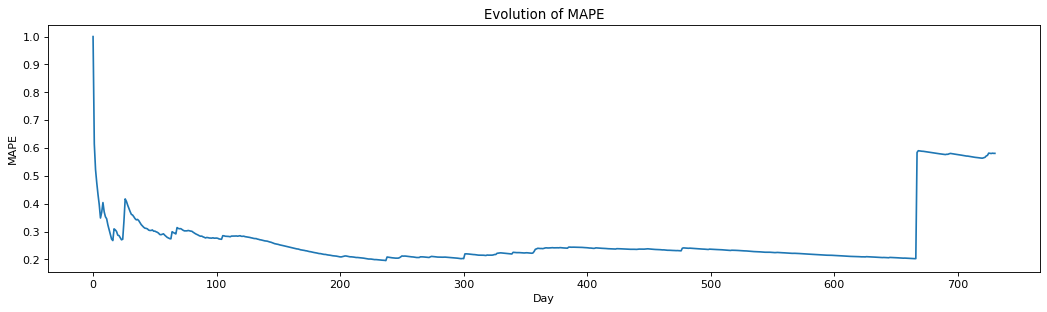

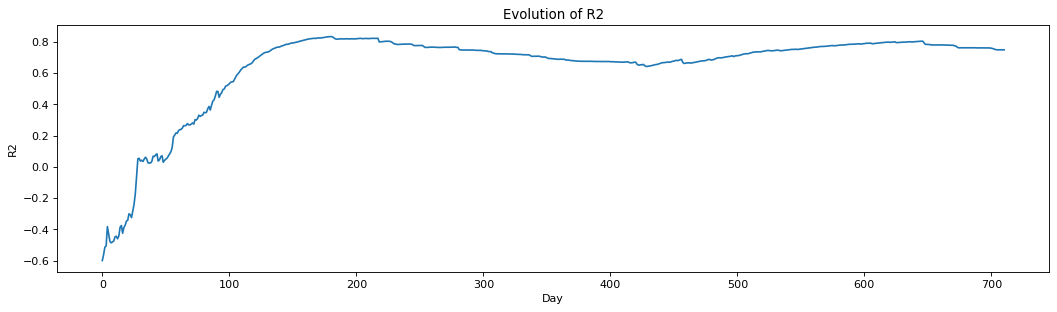

In [34]:
# Plot the continuous metrics
stream_knn_maes, stream_knn_rmses, stream_knn_mapes, stream_knn_r2s = zip(*knn_continuos_metrics)

# Transform MAPE in absolute value instead of percentage to mantain unformity with other plots
stream_knn_mapes = list(stream_knn_mapes)
for id in range(len(stream_knn_mapes)): stream_knn_mapes[id] = stream_knn_mapes[id]/100

plot_sml(stream_knn_maes, 'Evolution of MAE', 'Day', 'MAE')
plot_sml(stream_knn_rmses, 'Evolution of RMSE', 'Day', 'RMSE')
plot_sml(stream_knn_mapes, 'Evolution of MAPE', 'Day', 'MAPE')
plot_sml(stream_knn_r2s[20:], 'Evolution of R2', 'Day', 'R2')

This new "continous" plts give us a better look at how the SML models would have performed if deployed is a real case scenario. It important to look at this plot because, even if the comparison must be done using the "block" metrics, these plots give us a much better idea of the true SML performance.</br></br>
And as you can see, the strength of SML is obvious here. The MAPE for example steadily declines with each new day until it stabilizes around about 0.25, and it remains this low until it encounters the days of the 22 block. This performance are obviously extremely better than the use seen with ML, simply because the model can day by day improve obtaining more recent data instead of needing to way for a new batch to update itself. But once again, comparison must be fair, so we will continue to reference mainly the "blocks" data in our analysis.

### *Hoeffding Adaptive Tree*

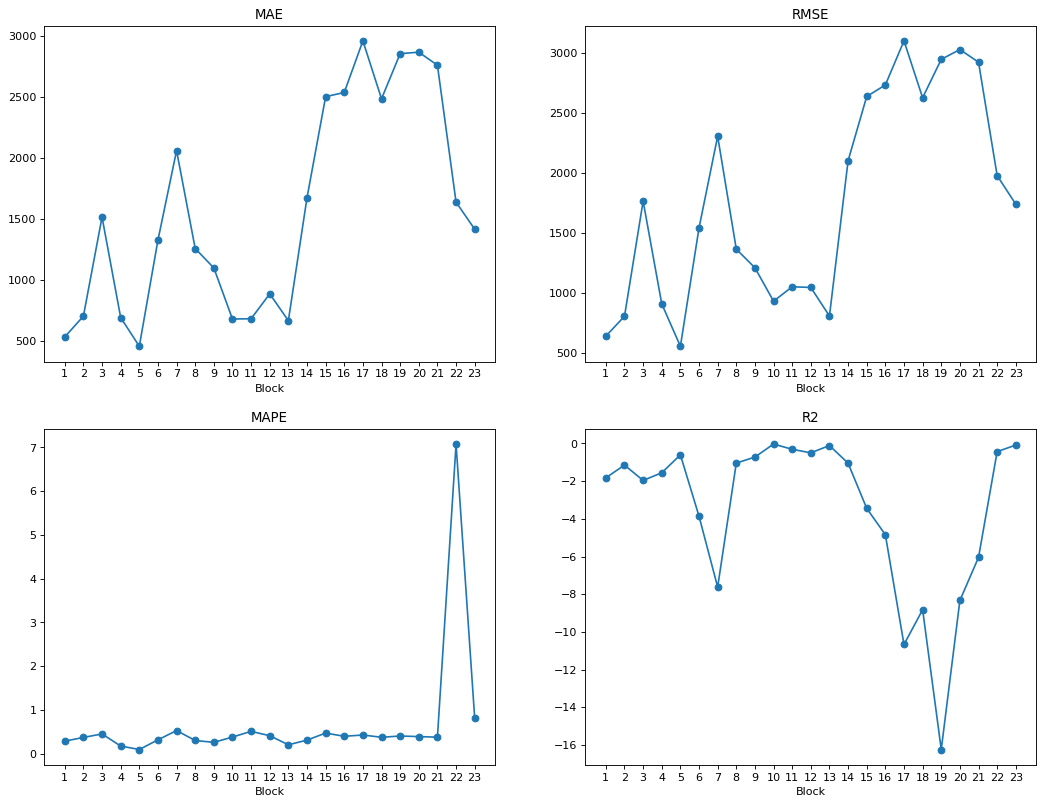

Final performance

MAE
  - Mean:  1578.415664039882
  - Stdev: 852.4513519951125
RMSE
  - Mean:  1770.9020230834537
  - Stdev: 847.7154199767249
MAPE
  - Mean:  0.6666523455310265
  - Stdev: 1.3739694929173183
R2
  - Mean:  -3.532940582720986
  - Stdev: 4.153655087728892
***********************************


In [19]:
from river.tree import HoeffdingAdaptiveTreeRegressor

# Instantiate the model
hat = HoeffdingAdaptiveTreeRegressor()
# Train and test the model
hat_metrics, hat_continuos_metrics = train_and_test_sml(hat)
# Plot the obtained metrics
plot_metrics(hat_metrics)
# Evaluate the model
evaluate_final(hat_metrics)

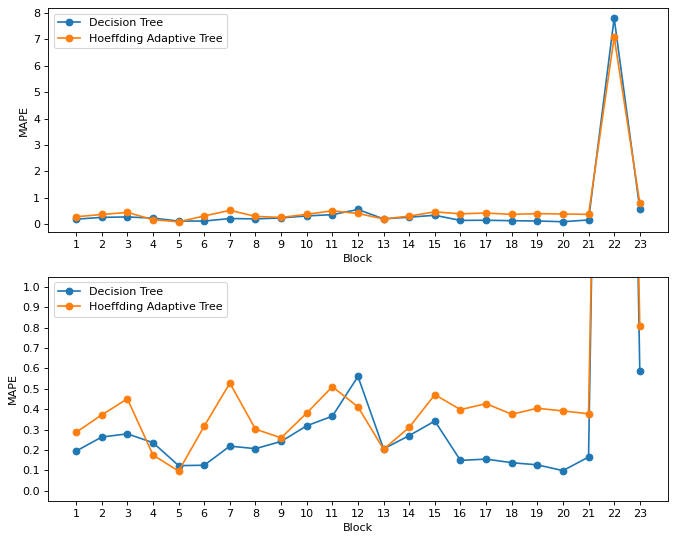

In [72]:
_, _, _ml_tree_mape, _ = zip(*tree_metrics)
_, _, _sml_tree_mape, _ = zip(*hat_metrics)
short_compare(_ml_tree_mape, _sml_tree_mape, ['Decision Tree', 'Hoeffding Adaptive Tree'])

In this case we see noticeably worse performance in respect to the standard Decision Tree. It simply looks like this model do not work well with our regression problem. Furthermore, the baseline still outperforms this model.

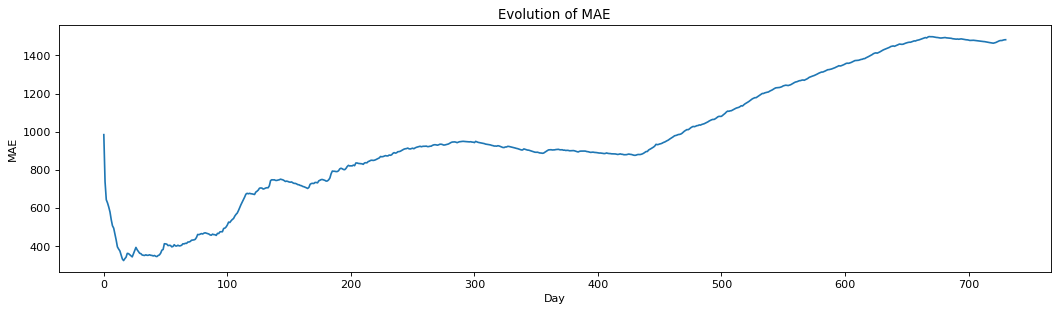

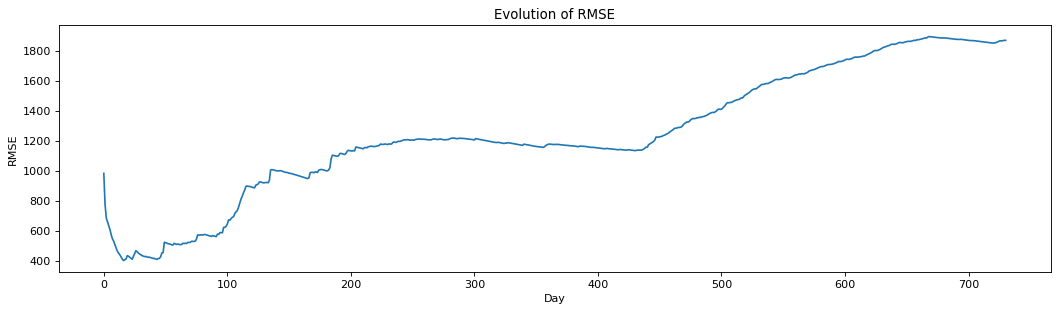

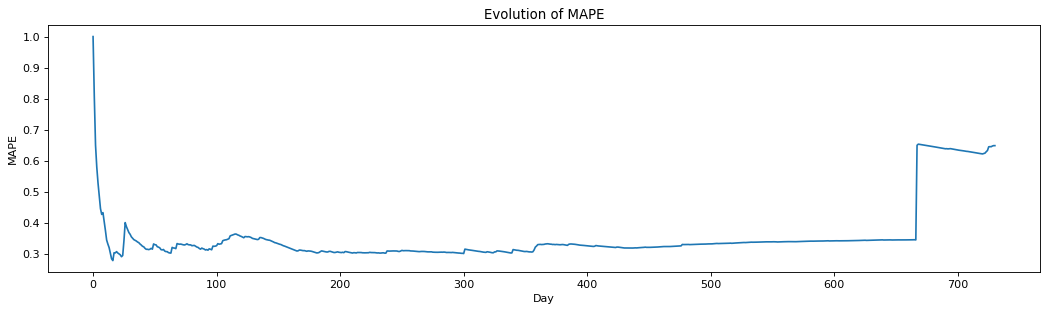

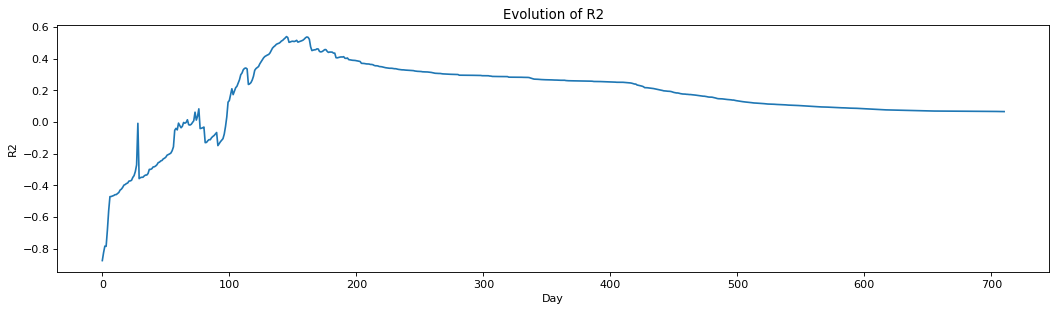

In [35]:
# Plot the continuous metrics
hat_maes, hat_rmses, hat_mapes, hat_r2s = zip(*hat_continuos_metrics)

# Transform MAPE in absolute value instead of percentage to mantain unformity with other plots
hat_mapes = list(hat_mapes)
for id in range(len(hat_mapes)): hat_mapes[id] = hat_mapes[id]/100

plot_sml(hat_maes, 'Evolution of MAE', 'Day', 'MAE')
plot_sml(hat_rmses, 'Evolution of RMSE', 'Day', 'RMSE')
plot_sml(hat_mapes, 'Evolution of MAPE', 'Day', 'MAPE')
plot_sml(hat_r2s[20:], 'Evolution of R2', 'Day', 'R2')

However, if we focus on the continuos evolution of the metrics, we can appreciate how the HAT model is still doing a decent job if deployed in a real scenario.

### *Adaptive Random Forest*

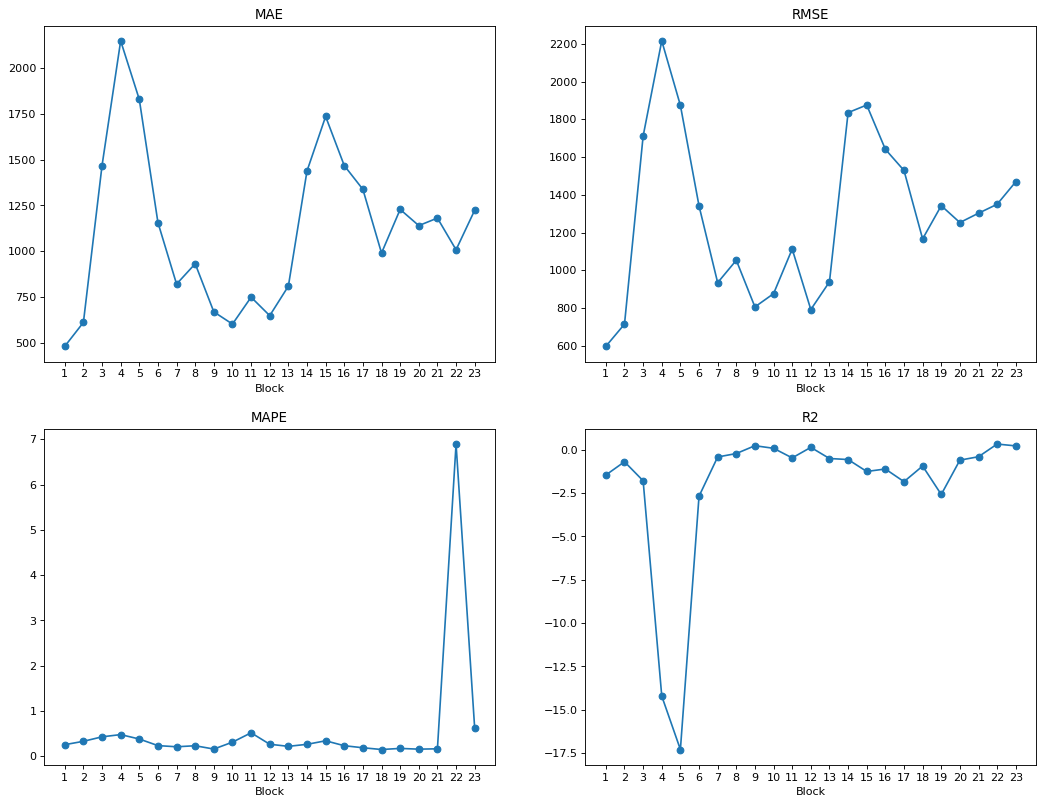

Final performance

MAE
  - Mean:  1116.8960822021204
  - Stdev: 421.3920608581065
RMSE
  - Mean:  1292.4913633031204
  - Stdev: 419.9813271683106
MAPE
  - Mean:  0.574927241026037
  - Stdev: 1.3533160771233492
R2
  - Mean:  -2.0861634477750433
  - Stdev: 4.320421628337749
***********************************


In [21]:
from river.forest import ARFRegressor

# Instantiate the model
arf = ARFRegressor(n_models=20)
# Train and test the model
arf_metrics, arf_continuos_metrics = train_and_test_sml(arf)
# Plot the obtained metrics
plot_metrics(arf_metrics)
# Evaluate the model
evaluate_final(arf_metrics)

This time the mean performance of Adaptive Random Forest shows a significantly increase in respect to the other SML models, but it's still worse thanour baseline. Once again, we still see the vertical increase in MAPE on the 22nd block. Yet, just like for HAT, the ARF model perform worse than its ML comparison as shown in the plot below.

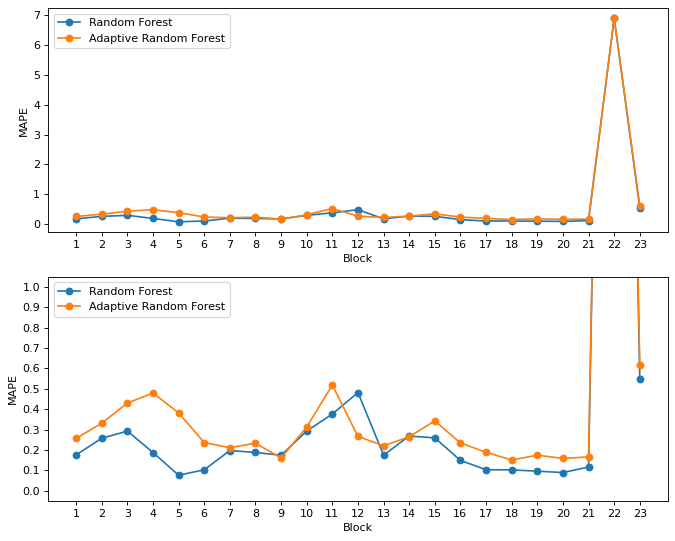

In [73]:
_, _, _ml_forest_mape, _ = zip(*forest_metrics)
_, _, _sml_forest_mape, _ = zip(*arf_metrics)
short_compare(_ml_forest_mape, _sml_forest_mape, ['Random Forest', 'Adaptive Random Forest'])

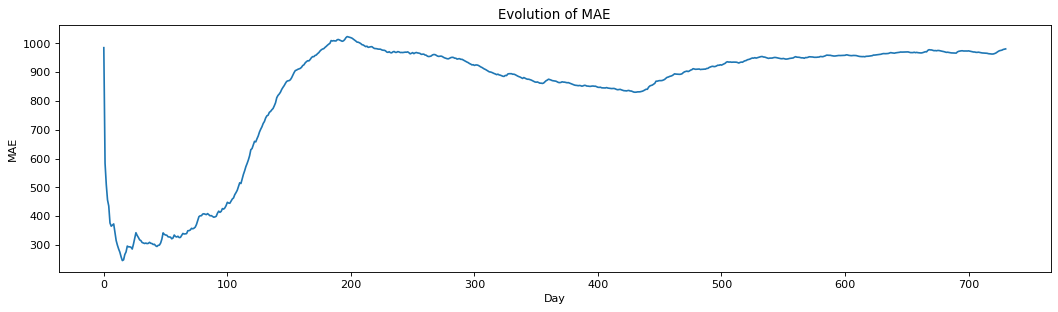

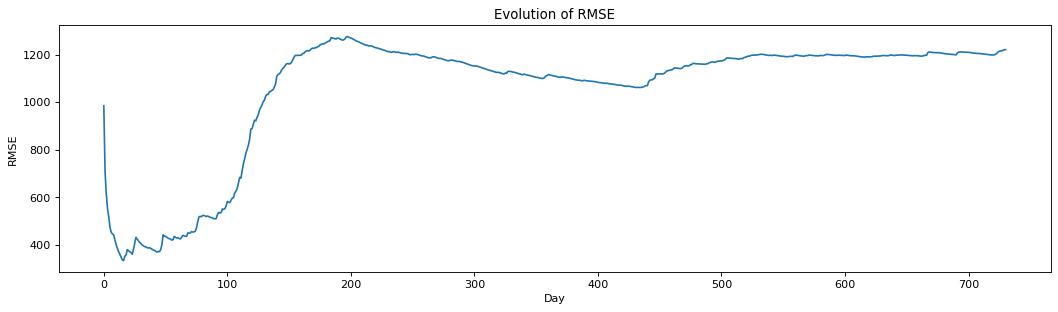

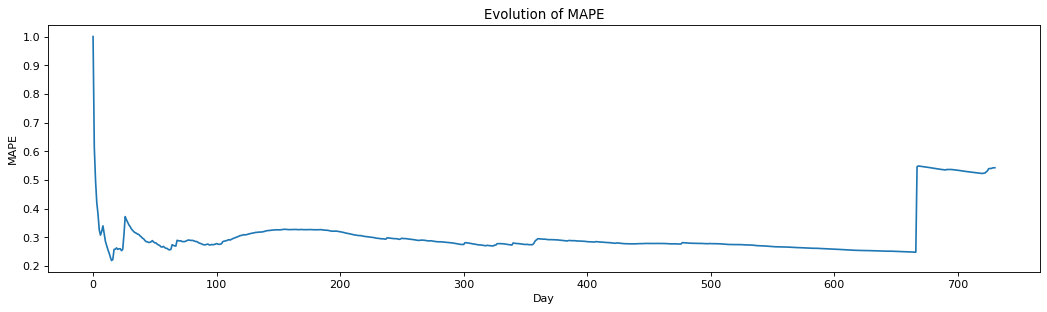

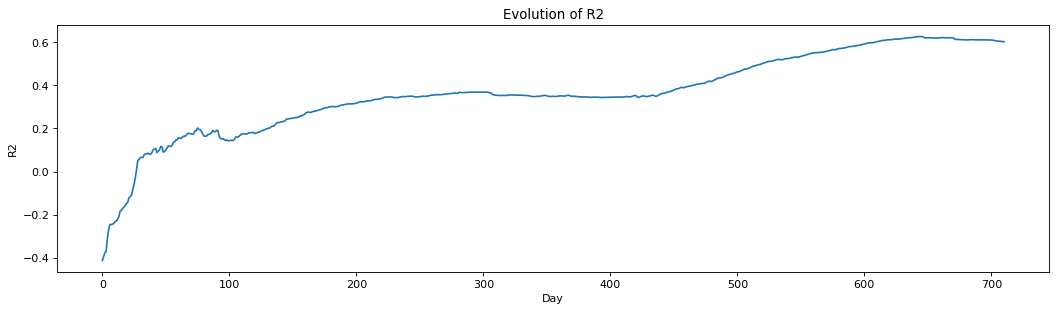

In [36]:
# Plot the continuous metrics
arf_maes, arf_rmses, arf_mapes, arf_r2s = zip(*arf_continuos_metrics)

# Transform MAPE in absolute value instead of percentage to mantain unformity with other plots
arf_mapes = list(arf_mapes)
for id in range(len(arf_mapes)): arf_mapes[id] = arf_mapes[id]/100

plot_sml(arf_maes, 'Evolution of MAE', 'Day', 'MAE')
plot_sml(arf_rmses, 'Evolution of RMSE', 'Day', 'RMSE')
plot_sml(arf_mapes, 'Evolution of MAPE', 'Day', 'MAPE')
plot_sml(arf_r2s[20:], 'Evolution of R2', 'Day', 'R2')

The continuos MAPE look fairly similar to the HAT one, maybe slightly better. It appears to manage noticeably better the day in the 22nd block, but in general it's not better than the SML KNN (not one contninuos metric is better than the SML KNN).

## **Streaming Machine Learning Results**

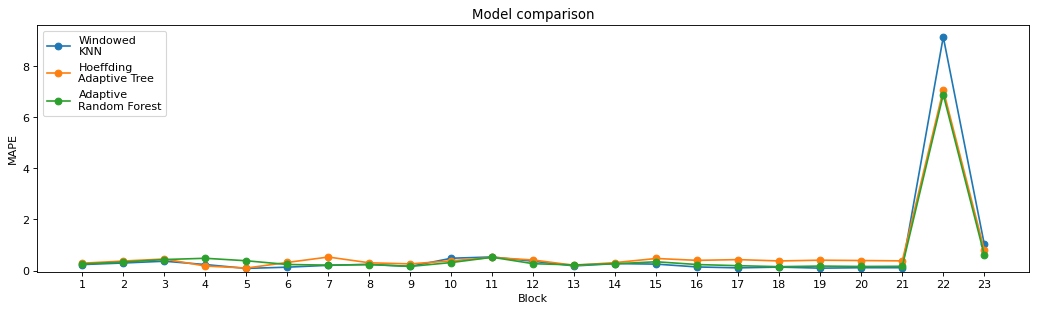

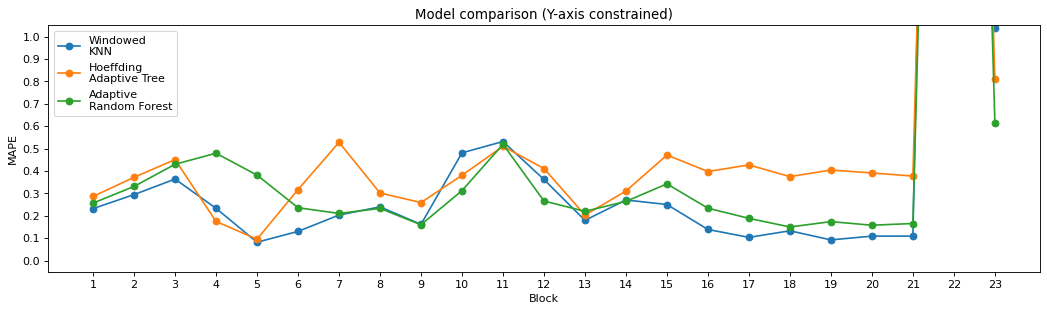

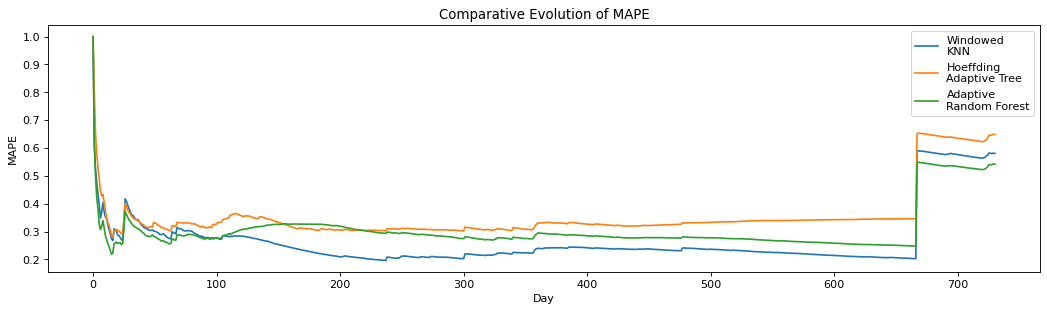

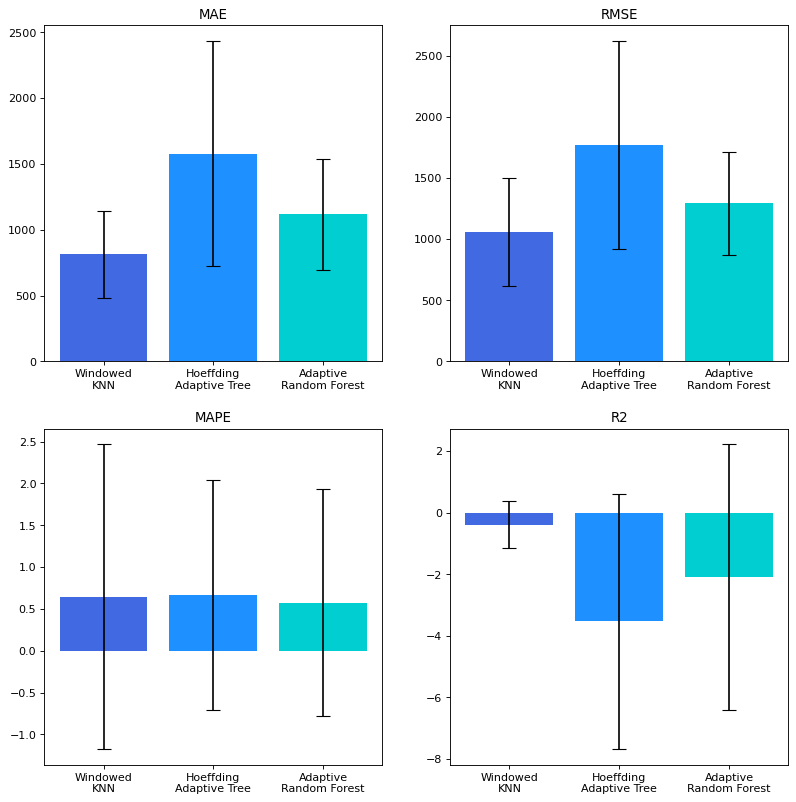

In [40]:
sml_metrics = [stream_knn_metrics, hat_metrics, arf_metrics]
sml_model_names = ['Windowed\nKNN', 'Hoeffding\nAdaptive Tree', 'Adaptive\nRandom Forest']
cross_compare(sml_metrics, sml_model_names, constrained=True, continuos=[stream_knn_mapes, hat_mapes, arf_mapes])

Looking at this final model comparison for the SML models, it appears clear that the SML KNN model it the best. Only in blocks 4, 10, 12, and 22 its MAPE is not the best. The mean MAPE it's not the top one, but it is mainly due to the horrible performances in the 22nd block, but all other mean metrics are the best of the SML models. Even the continuos metrics after day 100 show a significantly higher performancem, at least until we arrive in the days of the 22nd block, where the continuos MAPE of the ARF model beats the SML KNN.

## **Time series Analysis**

We'll use two simple but powerful models in our analysis:

- Holt-Winters
- SARIMA

Given the fundamentally different nature of Time Series Analysis (TSA) in respect to traditional ML and SML, we obviously cannot draw a direct comparison with the previous models and this two, but given our comparison framework, we'll try to be as insightful as possible.</br></br>

It must be noted that for TSA the testing is slightly different. Instead of using the entire consecutive block, we use only 25% of it. This is due to the nature of the TSA prediction: every time that we predict a value **y** at y<sub>t+1</sub>, this prediction is somewhat based on y<sub>t</sub>. This means that each time we have some error when predicting y<sub>t</sub>, it will be (at least partially) propagated to y<sub>t+1</sub>. Thus, the more far in the future we try to predict, the more we are accumulating error, decreasing the overall accuracy of the model. This problem is unique to TSA, thus to mitigate we decided to reduce the testing size to the previously mentioned 25% of each block.

### *Holt-Winters*

In [23]:
from statsmodels.tsa.api import ExponentialSmoothing

def get_Holt_Winters(data, seasonal_period=7, trend='mul', seasonal='mul'):
    return ExponentialSmoothing(data,
                              seasonal_periods=seasonal_period,
                              trend=trend, 
                              seasonal=seasonal,
                              use_boxcox=True,
                              initialization_method="estimated")

def train_and_test_hw(seasonal_period=7, trend='mul', seasonal='mul'):
    metrics = []
    train = BLOCKS[0]
    for block in BLOCKS[1:]:
        # Instantiate the model
        model = get_Holt_Winters(train[LABEL], seasonal_period, trend, seasonal)
        # Fit the data
        model = model.fit()
        # Test the model
        y_pred = model.forecast(len(block) // 4)
        # Evaluate the model
        metrics.append(evaluate_ml(block[LABEL][:len(block) // 4], y_pred))

        # Now we expand the training dataset
        train = pd.concat([train, block], axis=0)

    return metrics

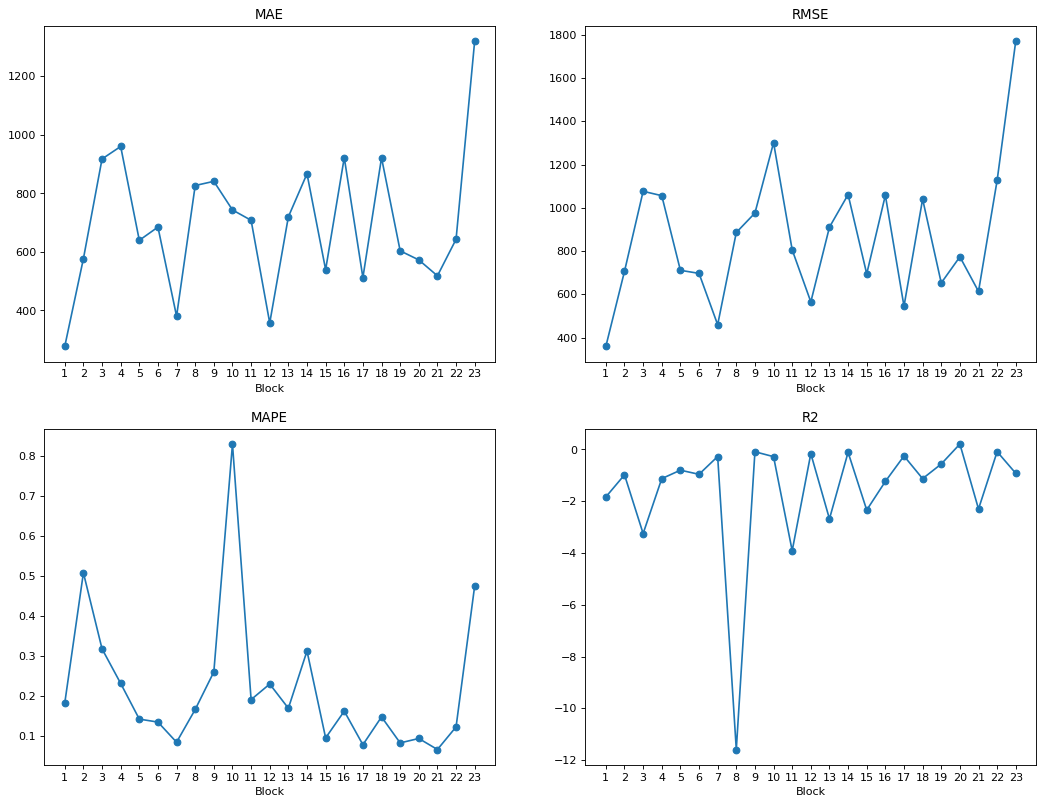

Final performance

MAE
  - Mean:  698.1800655357616
  - Stdev: 228.94341375939024
RMSE
  - Mean:  862.9314619973846
  - Stdev: 304.01802969725384
MAPE
  - Mean:  0.2213566638548666
  - Stdev: 0.17310159532040634
R2
  - Mean:  -1.5945074301092454
  - Stdev: 2.388317869918527
***********************************


In [24]:
import warnings
warnings.simplefilter('ignore')

# Train and test
holt_winters_metrics = train_and_test_hw(seasonal_period=14)
# Plot the obtained metrics
plot_metrics(holt_winters_metrics)
# Evaluate the model
evaluate_final(holt_winters_metrics)

For the first time, we have some extremely good result. Far better mean values than the baseline, and incredibly we don't see any particular MAPE spike in any block (even the 22nd block could not fool the model)! Still, in the R2 scores we sometimes see extremely negative spikes, but it is to be somewaht expected given that reducing to 25% the testing size means that the results are more significantly effected by outliears.

### *SARIMA*

In [25]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_and_test_sarima():
    idx = 1
    metrics = []
    train = BLOCKS[0]
    for block in BLOCKS[1:]:
        # First, we find the correct parameters using auto_arima
        # But we also cycle through the posssible seasonalities (daily = 7, monthly = 12, weekly = 52)
        idx += 1
        results = []
        for seasonality in [7, 12, 52]:
            try:
                arima = auto_arima(train[LABEL], trace=False, error_action='ignore', suppress_warnings=True, seasonal=True, m=seasonality)
                results.append(arima)
            except:
                pass

        # Obtain the best posible parameters
        best_params = sorted(results, key=lambda x: x.aic(), reverse=True)[0].get_params()
        # Instantiate the model
        model = SARIMAX(train[LABEL], order = best_params['order'], seasonal_order = best_params['seasonal_order'])
        # Fit the data
        model = model.fit()
        # Test the model
        y_pred = model.predict(start=len(train), end=(len(train)+len(block)//4-1), dynamic=False)
        # Evaluate the model
        metrics.append(evaluate_ml(block[LABEL][:len(block) // 4], y_pred))

        # Now we expand the training dataset
        train = pd.concat([train, block], axis=0)

    return metrics

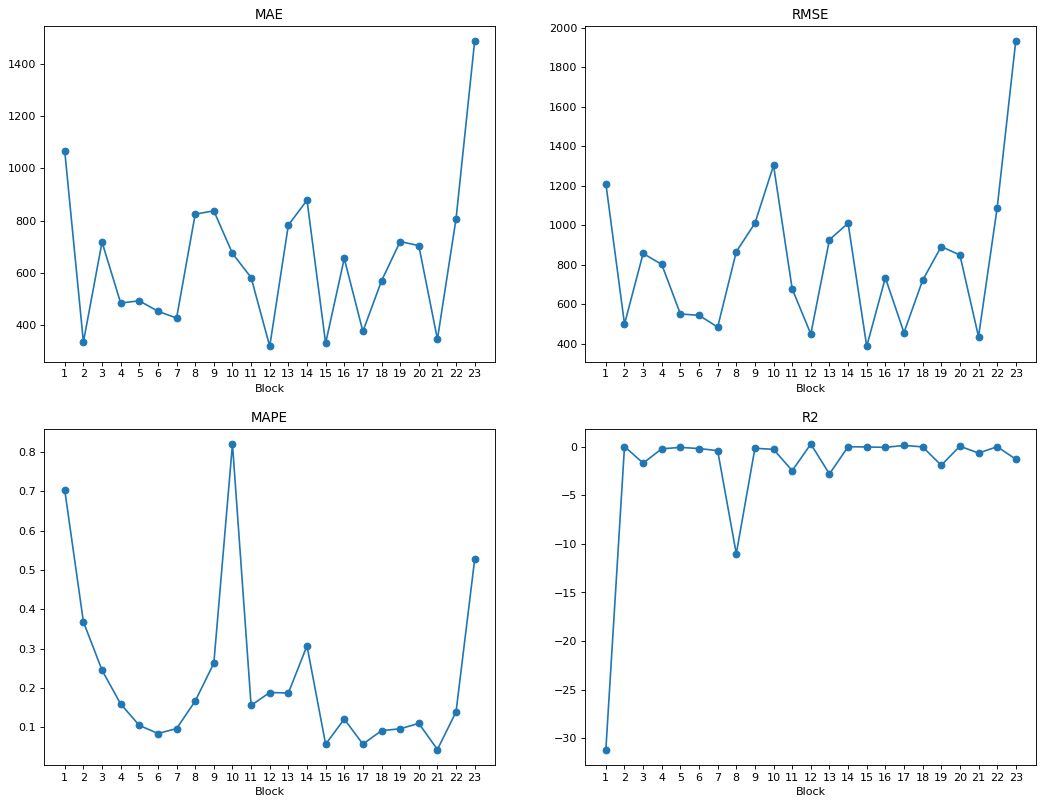

Final performance

MAE
  - Mean:  646.6885989876495
  - Stdev: 269.7009745601667
RMSE
  - Mean:  811.9781397236035
  - Stdev: 348.6629321988471
MAPE
  - Mean:  0.22143852527341235
  - Stdev: 0.2002117832214225
R2
  - Mean:  -2.350183219257405
  - Stdev: 6.552698220567172
***********************************


In [26]:
# Train and test
sarima_metrics = train_and_test_sarima()
# Plot the obtained metrics
plot_metrics(sarima_metrics)
# Evaluate the model
evaluate_final(sarima_metrics)

Once again, the TSA model far outperforms our baseline. No spikes in MAPE, but once again an horrible outlier in the first block of R2 score.

## **Time Series Analysis Results**

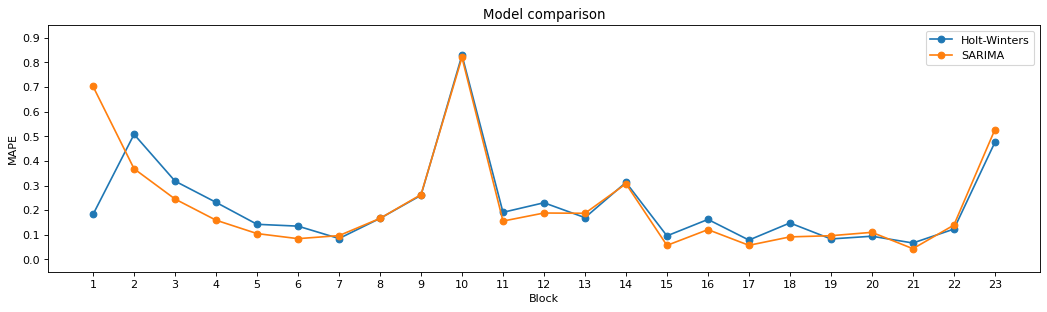

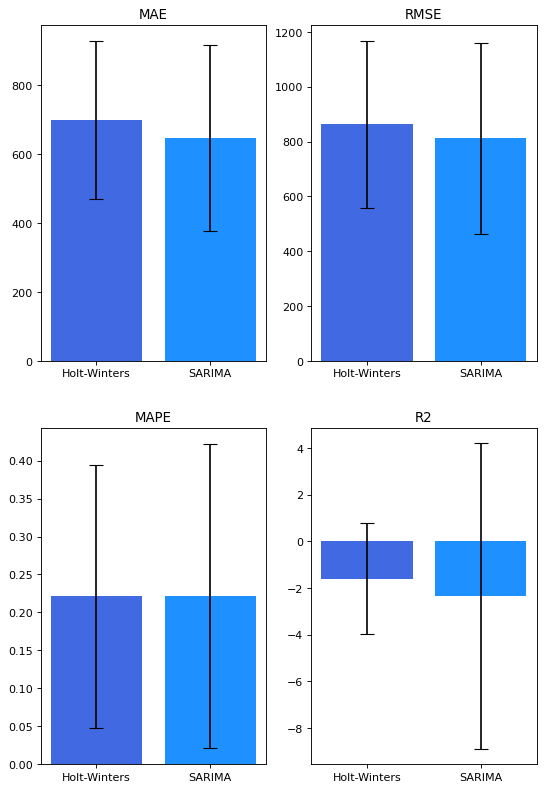

In [89]:
tsa_metrics = [holt_winters_metrics, sarima_metrics]
tsa_model_names = ['Holt-Winters', 'SARIMA']
cross_compare(tsa_metrics, tsa_model_names)

This comparison is the most difficult of the bunch, because we do not really have an absolute winner. Focusing on the mean values of the metrics, Holt-Winters has better R2 performance than SARIMA, similar MAPE, and worse MAE and RMSE. If we look at the block performance, we can see that SARIMA significanly perform worse on the 1st block, but after that it becomes comparable or even slightly better (like in blocks 2, 3, 4, 5, and 18) to Holt-Winters.

Based on the general performance, we can determine that SARIMA should be viewed as the best model. But there is something that we've never mentioned till now: execution time. Up until now, all models for all approaches were trained in at most 3 or 4 seconds, but SARIMA took almost 1 hour to complete its analysis. This is because it perform an automatic grid search to find its best parameters, and this is repeated for each block! Thus, even if SARIMA performs slightly better than Holt-Winters, this comes at a high computational cost.

## **Summary Results**

Now we are at the end of our approach comparison. It's time to compare each top models of each approach, and see which model is the general best!

The models are:

- Random Forest (*ML approach*)
- Windowed KNN (*SML approach*)
- SARIMA (*TSA approach*)

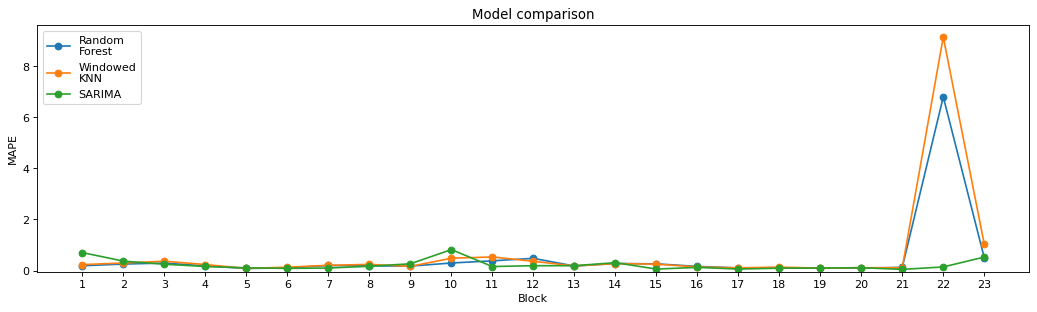

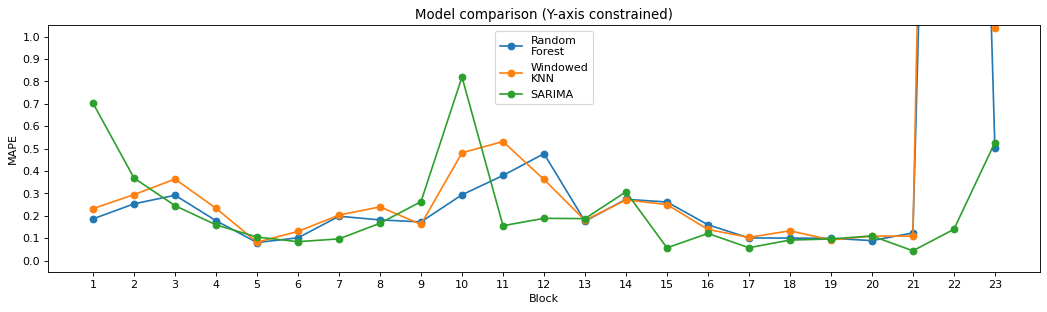

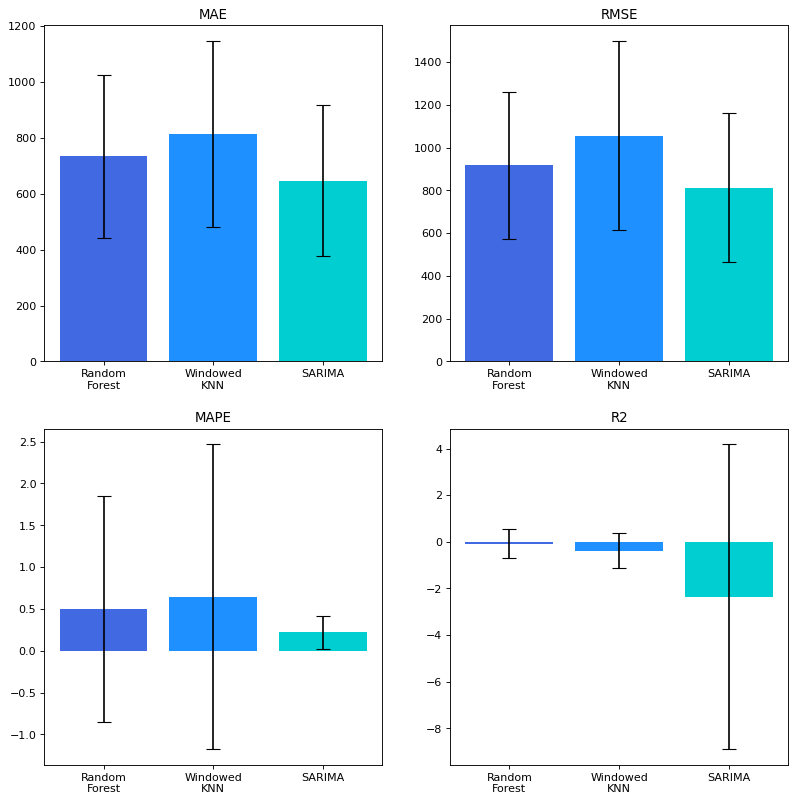

In [90]:
summary_metrics = [forest_metrics, stream_knn_metrics, sarima_metrics]
summany_model_names = ['Random\nForest', 'Windowed\nKNN', 'SARIMA']
cross_compare(summary_metrics, summany_model_names, constrained=True)

The block MAPE of SARIMA perform better or comparably in all blocks except for block 1, 2, 9 and 10. But it has the absolute advantage of not exploding on the 22nd block. Same story for the mean metrics, SARIMA is consistenyl the best apart for R2 score (but we must remember that the R2 score of SARIMA was affected by an extreme outlier in the firs block).

This simply tells us one thing: SARIMA clearly is the best model!
Who would have thought that a time series problem would be solved in the best way using Time Series analysis?

## **Conlusions**

In this notebook we first defined a commmon evaluation framework, in order to be able to compare different approached to our problem.</br>
Then we compared the traditional ML, SML, and TSA approach to this regression task, using multiple models.

We have found out that (probably as expected) a time series problem should be approached using TSA. At the same time the SML approach (if deployed in a realistic setting, thus looking at the "continuos" metrics) showed us how its performance are not that far off TSA, and could be chosen as a valid alternative to SARIMA in a real setting (especially if we consider the extreme difference in computational cost between ARF and SARIMA).